TokaMaker Example: Reconstruction with eddy current modes in LTX {#doc_tMaker_LTX_ex3}
==========
In this example we show how eddy current patterns can be included in reconstructions of LTX-&beta;, including:
 1. Computing characteristic eddy current modes for the VV and Shell and adding them to the equilibrium as coil-like free parameters
 2. Constraining an inverse equilibrium with flux measurements
 3. Performing a full reconstruction

This example utilizes the mesh built in \ref doc_tMaker_LTX_ex1.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python package, which is installable using `pip` or other standard methods.

In [1]:
import os
import sys
import time
import copy
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain()" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, create_spline_flux_fun

## Compute eddy current modes

First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

Then we load the mesh generated in \ref doc_tMaker_LTX_ex1 using \ref OpenFUSIONToolkit.TokaMaker.load_gs_mesh "load_gs_mesh()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh()".

In [3]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('LTX_mesh.h5')
myOFT = OFT_env(nthreads=2)
mygs = TokaMaker(myOFT)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tMaker_eddy_modes
Revision id:          3292182
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = /var/folders/52/n5qxh27n4w19qxzqygz2btbw0000gn/T/oft_30794/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Compute eddy current modes for the VV
Now we build a model of LTX-$\beta$ where the resistivity in the shell is increased to isolate eddy currents in the VV. To do this we copy the `cond_dict` object loaded above and modify the `eta` values for the two shell regions.

Then we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions()" to define the different region types and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup()" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

In [4]:
cond_dict_vv = copy.deepcopy(cond_dict)
cond_dict_vv['SHELLU']['eta']=1.E2
cond_dict_vv['SHELLL']['eta']=1.E2
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict_vv,coil_dict=coil_dict)
mygs.setup(order=2, F0=0.10752)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.640E+00
    # of points  =    3510
    # of edges   =   10387
    # of cells   =    6878
    # of boundary points =     140
    # of boundary edges  =     140
    # of boundary cells  =     140
  Resolution statistics:
    hmin =  2.294E-03
    hrms =  3.166E-02
    hmax =  7.421E-02
  Surface grounded at vertex     783


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    2.3040000000000001E-003


With the model setup we can now compute the characteristic eigenmodes of the VV conductors, which we save to use as part of our eddy current mode basis later on.

Longest L/R time = 4.3364E-03 [s]


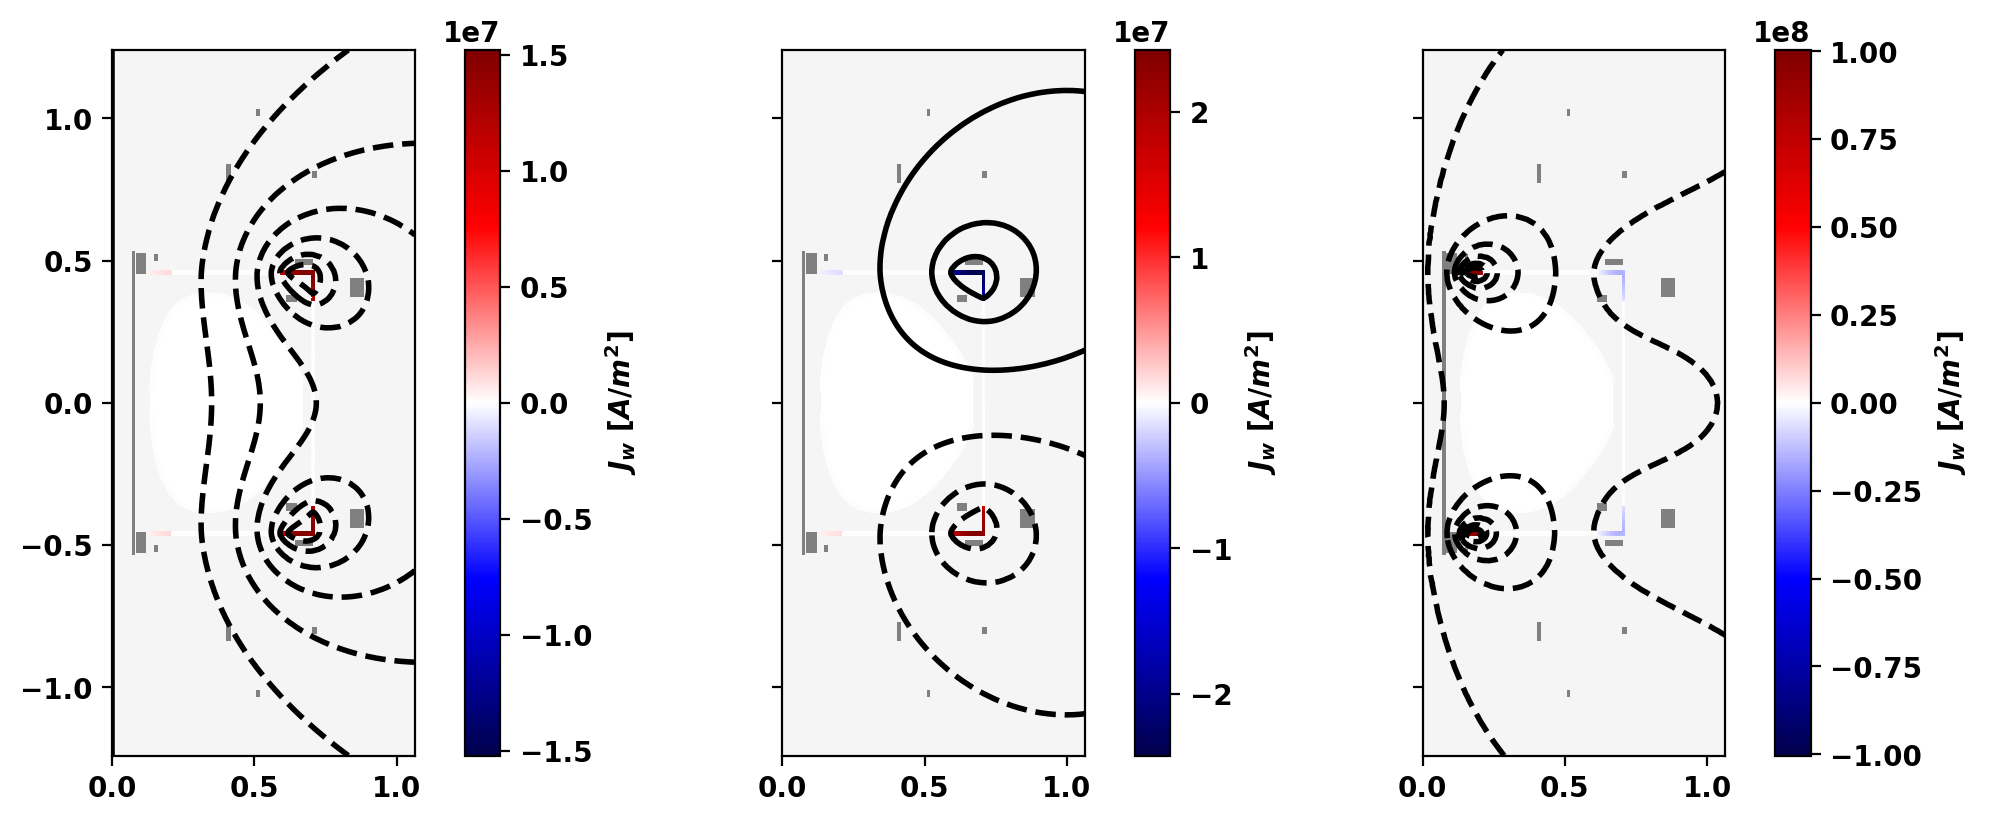

In [5]:
eig_vals, eig_vecs = mygs.eig_wall(10)
fig, ax = plt.subplots(1,3,sharey=True,figsize=(10,4),constrained_layout=True)
for i in range(3):
    mygs.plot_machine(fig,ax[i],limiter_color=None)
    mygs.plot_psi(fig,ax[i],eig_vecs[i,:],xpoint_color=None,opoint_color=None,normalized=False,plasma_color='k')
    mygs.plot_eddy(fig,ax[i],dpsi_dt=eig_vecs[i,:]*abs(eig_vals[i,0]),colormap='seismic',symmap=True)
print('Longest L/R time = {0:.4E} [s]'.format(1.0/eig_vals[0,0]))
vv_eigs = eig_vecs.copy()

### Setup shell-only LTX-$\beta$ model
Now we reset the TokaMaker object and rebuild a model where the resistivity in the VV is increased to isolate eddy currents in the shell. To do this we copy the `cond_dict` object loaded above and modify the `eta` values for all VV regions.

In [6]:
mygs.reset()
cond_dict_shell = copy.deepcopy(cond_dict)
for key in cond_dict_shell:
    if key.startswith('VV'):
        cond_dict_shell[key]['eta']=1.E3
mygs.settings.maxits=80
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict_shell,coil_dict=coil_dict)
mygs.setup(order=2, F0=0.10752)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.640E+00
    # of points  =    3510
    # of edges   =   10387
    # of cells   =    6878
    # of boundary points =     140
    # of boundary edges  =     140
    # of boundary cells  =     140
  Resolution statistics:
    hmin =  2.294E-03
    hrms =  3.166E-02
    hmax =  7.421E-02
  Surface grounded at vertex     783


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    1.9610000000000001E-003


With the new model setup we can now compute the characteristic eigenmodes of the Shell+VV conductors, which is dominated by the shell due to its low resistivity.

Longest L/R time = 3.0683E-03 [s]


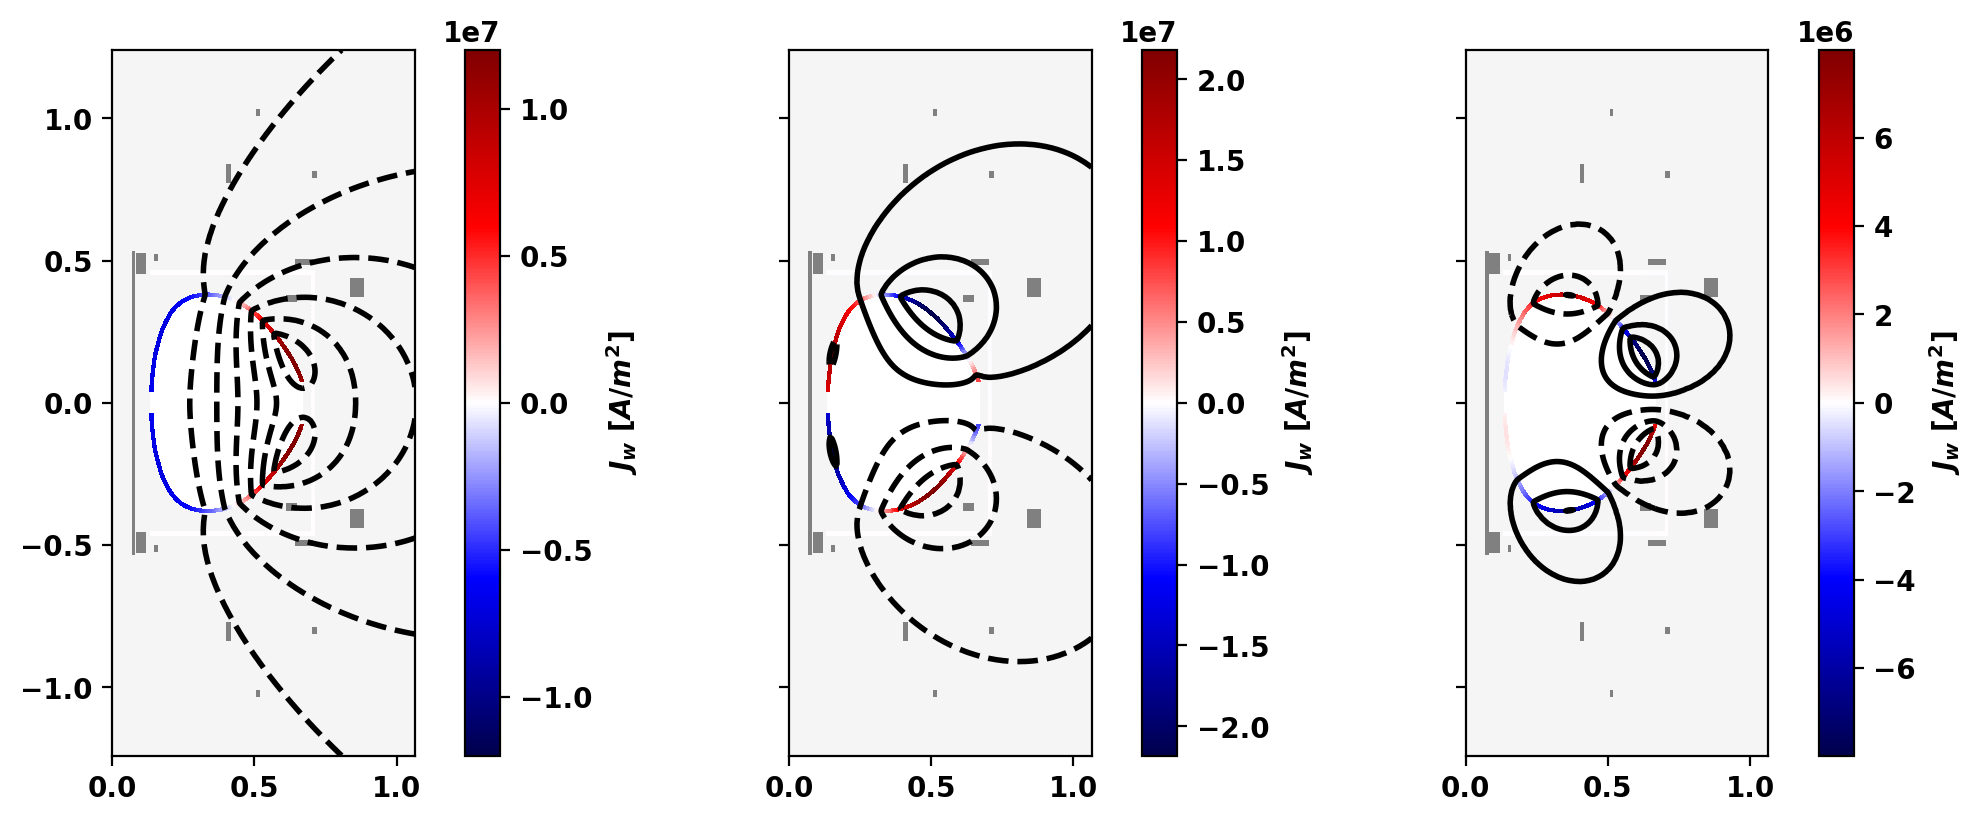

In [7]:
eig_vals, eig_vecs = mygs.eig_wall(10)
fig, ax = plt.subplots(1,3,sharey=True,figsize=(10,4),constrained_layout=True)
for i in range(3):
    mygs.plot_machine(fig,ax[i],limiter_color=None)
    mygs.plot_psi(fig,ax[i],eig_vecs[i,:],xpoint_color=None,opoint_color=None,normalized=False,plasma_color='k')
    mygs.plot_eddy(fig,ax[i],dpsi_dt=eig_vecs[i,:]*abs(eig_vals[i,0]),colormap='seismic',symmap=True)
print('Longest L/R time = {0:.4E} [s]'.format(1.0/eig_vals[0,0]))

### Setup normal LTX-$\beta$ model
Now we reset the TokaMaker object and rebuild the model using the original `cond_dict` definitions.

In [8]:
mygs.reset()
mygs.settings.maxits=80
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2, F0=0.10752)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.640E+00
    # of points  =    3510
    # of edges   =   10387
    # of cells   =    6878
    # of boundary points =     140
    # of boundary edges  =     140
    # of boundary cells  =     140
  Resolution statistics:
    hmin =  2.294E-03
    hrms =  3.166E-02
    hmax =  7.421E-02
  Surface grounded at vertex     783


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    1.9000000000000000E-003


### Define eddy current basis
We now build an eddy current mode basis from the longest-lived shell+VV mode and the 1st and 3rd longest-lived VV modes. Then we add these modes to the model using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_cond_modes "set_cond_modes()". Once added these modes can now contribute to inverse equilibrium solves and reconstructions, by varying their amplitude with fixed current distribution -- similar to how coils work.

In [9]:
nmodes = np.zeros((mygs.nregs,),dtype=np.int32)
nmodes[0] = 3
cond_modes = np.vstack((eig_vecs[0,:],vv_eigs[[0,2],:]))
mygs.set_cond_modes(nmodes,cond_modes)

### Finish model setup
As with other LTX-$\beta$ examples we use the "INTERNAL" coils as VSC coils and define a simple cubic flux function, using \ref OpenFUSIONToolkit.TokaMaker.util.create_spline_flux_fun "create_spline_flux_fun()", with the same shape for both F\*F' and P'.

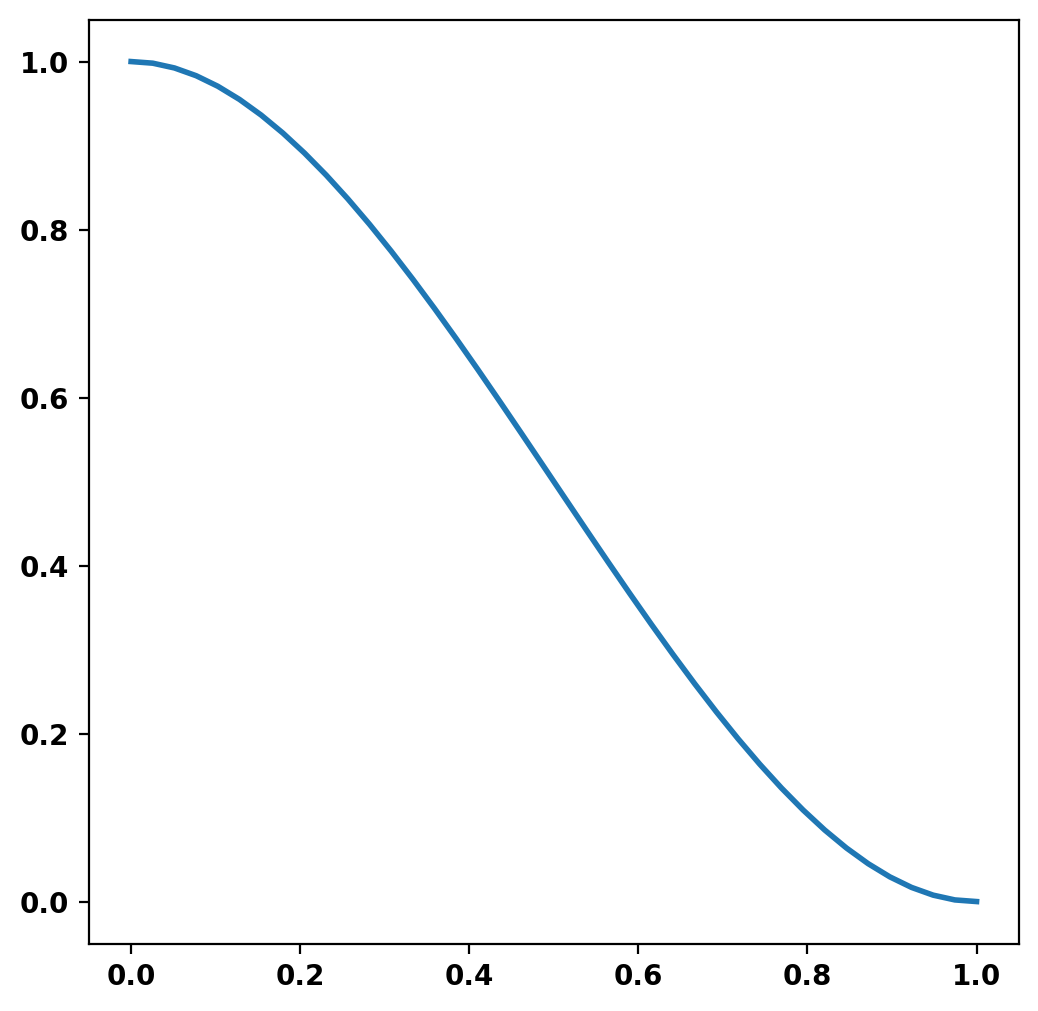

In [10]:
mygs.set_coil_vsc({'INTERNALU': 1.0, 'INTERNALL': -1.0})

prof = create_spline_flux_fun(40,[0.0,0.5,1.0],[1.0,0.5,0.0],axis_bc=[1,0.0],edge_bc=[1,0.0])
plt.plot(prof['x'],prof['y'])
mygs.set_profiles(ffp_prof=prof,pp_prof=prof)

## Compute inverse equilibrium


In [11]:
with open('LTX_exp_data.json','r') as fid:
    exp_data = json.load(fid)
#
floop_locs = []
floop_vals = []
for floop in exp_data['floops']:
    if floop.get('err_fac',1.0) > 0.0 and floop['val'] is not None:
        floop_locs.append(floop['loc'])
        floop_vals.append(-floop['val'])

In [12]:
# Replace shape constraints with absolute flux and current constraints
mygs.set_isoflux(None)
mygs.set_saddles(None)
mygs.set_targets(Ip=-exp_data['ip'],Ip_ratio=2.0)
mygs.set_flux(np.array(floop_locs),np.array(floop_vals)/2.0/np.pi)

# Set coil regularization to weekly track measured coil currents
coil_targets = {}
regularization_terms = []
for name, coil in mygs.coil_sets.items():
    exp_name = name.lower()
    if name[-1] == 'U' or name[-1] == 'L':
        exp_name = name[:-1].lower()
    regularization_terms.append(mygs.coil_reg_term({name: 1.0},target=-exp_data['coils'][exp_name],weight=1.E1))
    coil_targets[name] = -exp_data['coils'][exp_name]
# Set zero target current and small weight on virtual VSC to allow up-down adjustment
regularization_terms.append(mygs.coil_reg_term({'#VSC': 1.0},target=0.0,weight=1.E2))

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(reg_terms=regularization_terms)

# Initial equilibrium with very rough guess
err_flag = mygs.init_psi(0.42,0.0,0.15,1.5,0.6)

# Update maximum number of solver iterations
mygs.settings.maxits=100
mygs.settings.urf=0.2
mygs.update_settings()

# Compute initial equilibrium
err_flag = mygs.solve()

Starting non-linear GS solver
     1  6.1206E-01  1.1398E+00  8.2968E-04  4.0531E-01 -2.1618E-04 -3.9867E-02
     2  7.4207E-01  1.3398E+00  3.2368E-04  4.0650E-01 -2.2563E-04 -4.0499E-02
     3  8.0173E-01  1.4228E+00  1.8113E-04  4.0814E-01 -2.3576E-04 -4.0905E-02
     4  8.3207E-01  1.4600E+00  1.1550E-04  4.0964E-01 -2.4937E-04 -4.1153E-02
     5  8.4808E-01  1.4764E+00  7.6627E-05  4.1080E-01 -2.7803E-04 -4.1295E-02
     6  8.5670E-01  1.4832E+00  5.1812E-05  4.1167E-01 -3.1114E-04 -4.1362E-02
     7  8.6142E-01  1.4857E+00  3.5368E-05  4.1231E-01 -3.4228E-04 -4.1376E-02
     8  8.6404E-01  1.4862E+00  2.4218E-05  4.1277E-01 -3.7164E-04 -4.1355E-02
     9  8.6552E-01  1.4860E+00  1.6586E-05  4.1310E-01 -3.9947E-04 -4.1311E-02
    10  8.6637E-01  1.4855E+00  1.1351E-05  4.1333E-01 -4.2591E-04 -4.1252E-02
    11  8.6687E-01  1.4851E+00  7.7609E-06  4.1348E-01 -4.5116E-04 -4.1184E-02
    12  8.6717E-01  1.4847E+00  5.3056E-06  4.1359E-01 -4.7535E-04 -4.1110E-02
    13  8.6735E-01  1.

### Compare flux loop signals

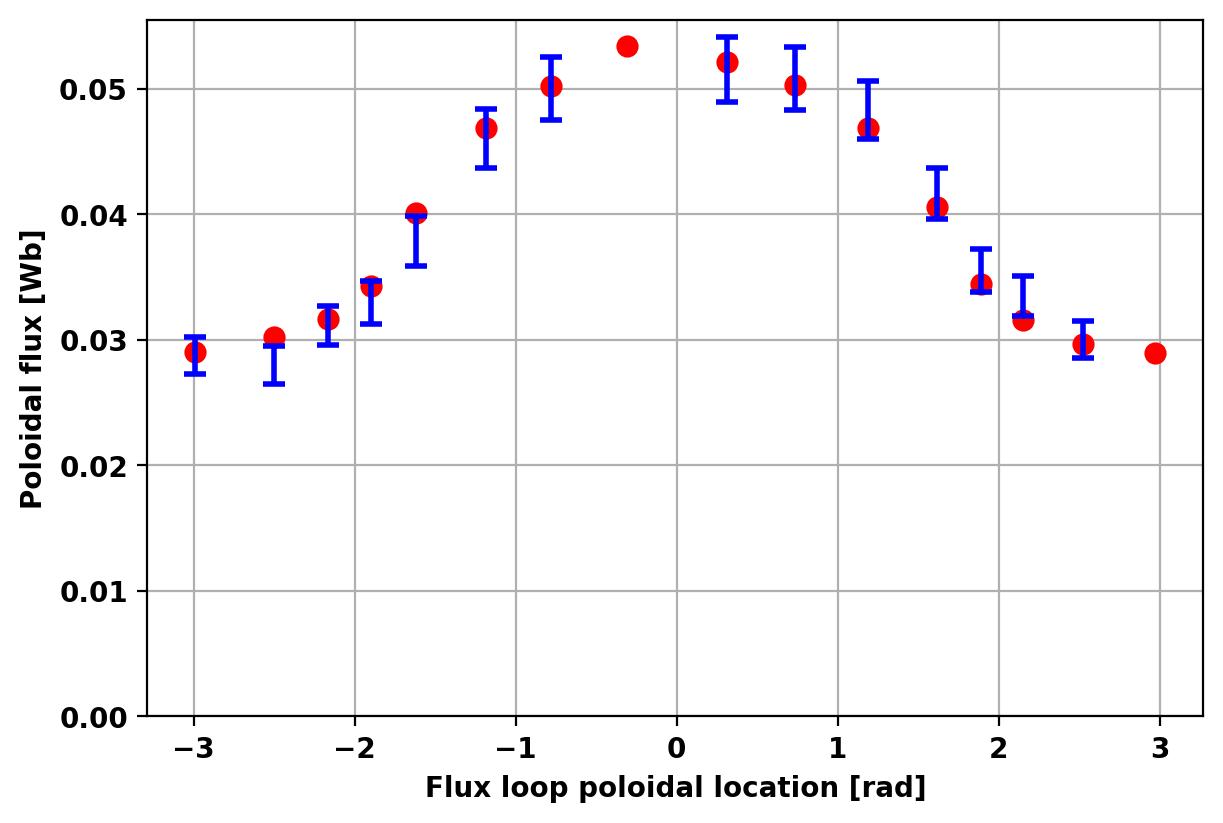

In [13]:
field_eval = mygs.get_field_eval('PSI')
fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(6,4))
for floop in exp_data['floops']:
    theta = np.arctan2(floop['loc'][1],floop['loc'][0]-0.42)
    B_tmp = field_eval.eval(floop['loc'])
    if floop['name'].startswith('CENTERSTACK'):
        continue
    ax.plot(theta,-B_tmp[0]*2.0*np.pi,'ro')
    if floop.get('err_fac',1.0) > 0.0 and floop['val'] is not None:
        ax.errorbar(theta,floop['val'],yerr=0.05*abs(B_tmp[0]*2.0*np.pi),color='b',capsize=4)
ax.set_ylim(bottom=0.0)
ax.grid(True)
ax.set_xlabel('Flux loop poloidal location [rad]')
_ = ax.set_ylabel('Poloidal flux [Wb]')

### Plot equilibrium and eddy currents
We now show the updated equilibrium, this time using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_eddy "plot_eddy()" to show the eddy currents in the vessel due to the change in flux from the preceding equilibrium.

Starting CG solver
     0  0.000000E+00  0.000000E+00  3.671669E-01
     1 -5.492947E+02  3.798485E+03  1.748104E-01  4.602107E-05
     2 -6.529642E+02  4.018711E+03  7.054081E-02  1.755309E-05
     3 -6.692494E+02  4.110531E+03  2.569580E-02  6.251212E-06
     4 -6.716508E+02  4.123009E+03  1.077250E-02  2.612777E-06
     5 -6.719956E+02  4.121731E+03  3.636405E-03  8.822519E-07
     6 -6.720430E+02  4.115405E+03  1.409570E-03  3.425105E-07
     7 -6.720511E+02  4.115501E+03  5.352348E-04  1.300534E-07
     8 -6.720521E+02  4.115768E+03  2.511455E-04  6.102032E-08
     9 -6.720524E+02  4.115842E+03  9.087238E-05  2.207868E-08
    10 -6.720524E+02  4.115905E+03  3.113046E-05  7.563455E-09
    20 -6.720524E+02  4.115887E+03  2.235346E-09  5.431018E-13
Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    1.0326E+05
  Current Centroid [m]    =    0.385 -0.001
  Magnetic Axis [m]       =    0.414 -0.001
  Elongation              =    1.231 (U:  1.231

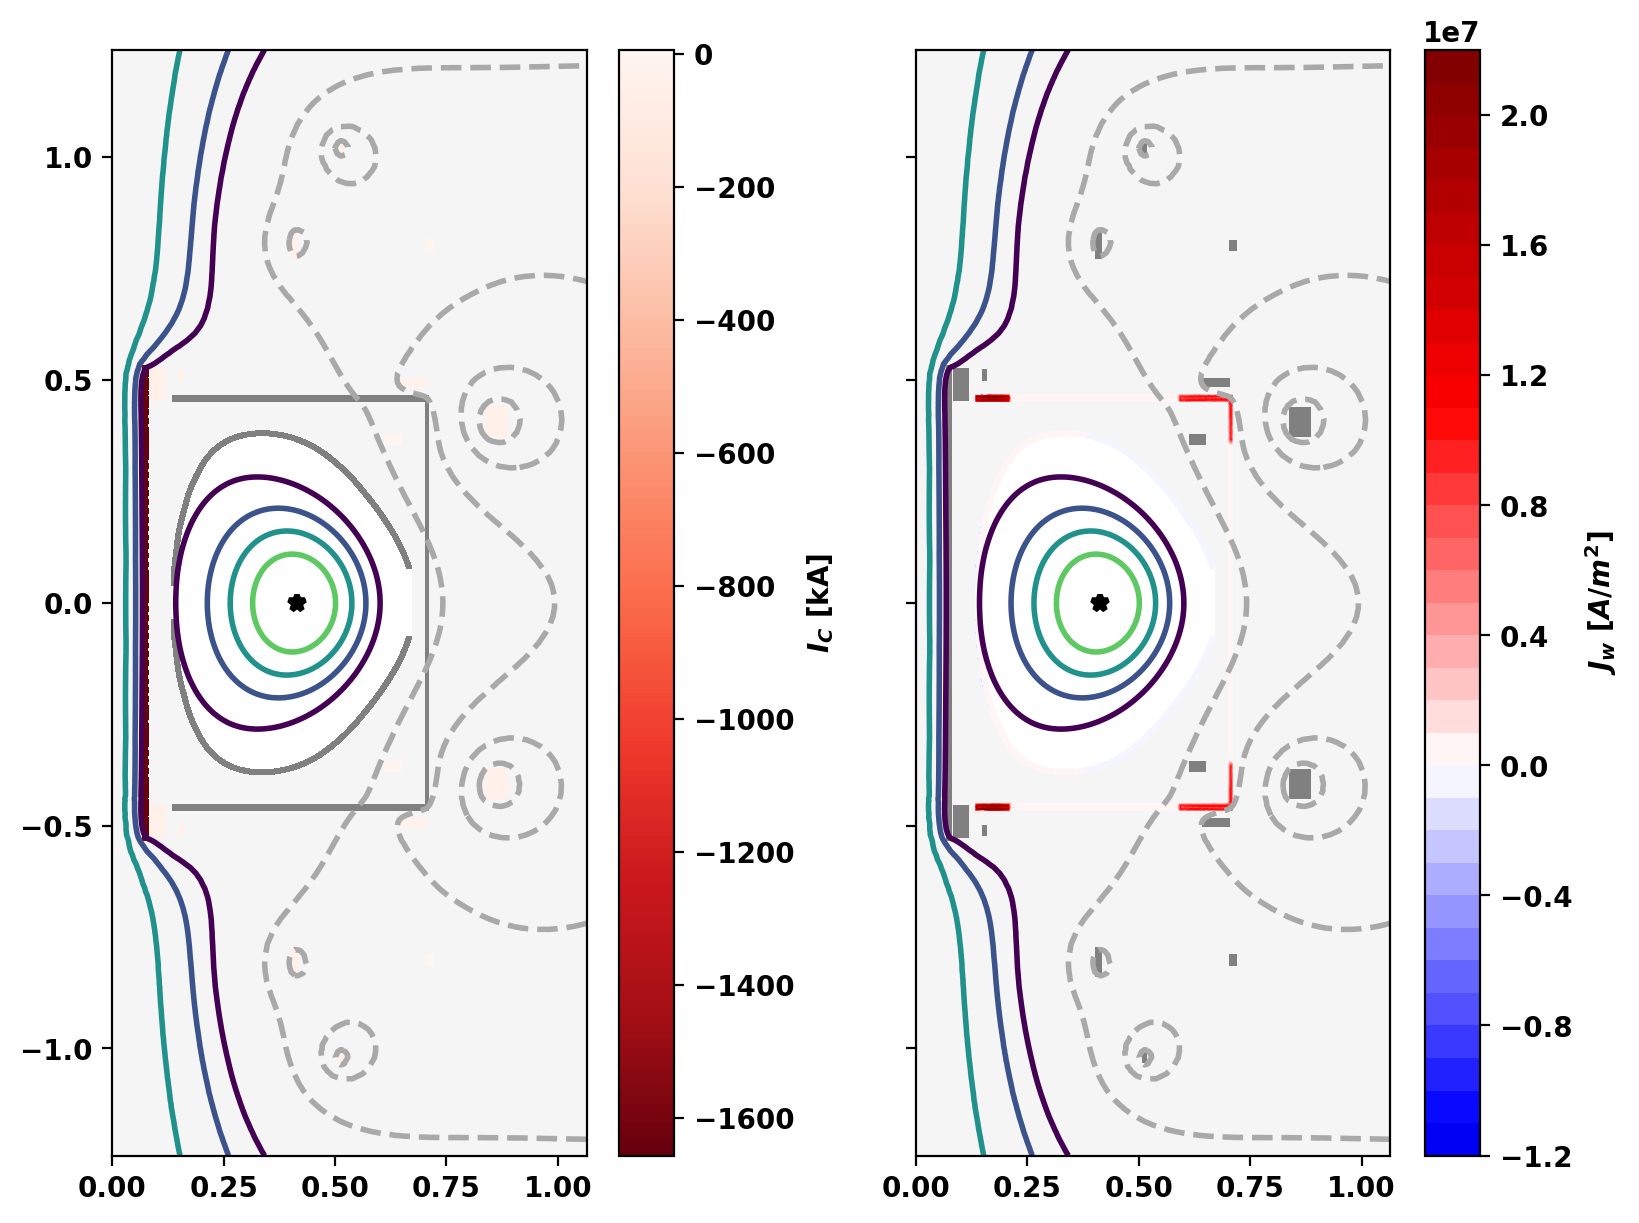

In [14]:
# Plot equilibrium
fig, ax = plt.subplots(1,2,sharey=True,constrained_layout=True,figsize=(8,6))
mygs.plot_machine(fig,ax[0],coil_colormap='Reds_r',coil_scale=1.E-3,coil_clabel=r'$I_C$ [kA]',limiter_color=None)
mygs.plot_psi(fig,ax[0],plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_machine(fig,ax[1],limiter_color=None)
mygs.plot_psi(fig,ax[1],plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_eddy(fig,ax[1],psi=mygs.get_psi(False),colormap='seismic',symmap=True)
# Print information and coil currents
mygs.print_info()
print()
print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key in coil_currents:
    print('  {0:10} {1:10.2F}'.format(key+":",coil_currents[key]/1.E3))

## Compute equilibrium reconstruction

In [15]:
from OpenFUSIONToolkit.TokaMaker.reconstruction import reconstruction
myrecon = reconstruction(mygs)
for floop in exp_data['floops']:
    if floop.get('err_fac',1.0) > 0.0 and floop['val'] is not None:
        myrecon.add_flux_loop(floop['loc'],-floop['val'], err=abs(floop['val']*0.05))
myrecon.set_Ip(-exp_data['ip'], err=abs(0.05*exp_data['ip']))
myrecon.set_DFlux(exp_data['dflux'], err=abs(0.1*exp_data['dflux']))
myrecon.set_coil_currents(coil_targets, err={name: abs(0.05*coil_targets[name]) for name in coil_targets})

# Remove all shape constraints
mygs.set_isoflux(None)
mygs.set_flux(None,None)
mygs.set_saddles(None)

# Set initial position targets from current values
mygs.set_targets(R0=mygs.o_point[0],V0=mygs.o_point[1])

# Set reconstruction settings
myrecon.settings.fitPnorm = False
myrecon.settings.fitR0 = True
myrecon.settings.pm = False

# Perform reconstructions
err_flag = myrecon.reconstruct()


*** Loading fit constraints ***
 Setting nonax           2   1.0000000000000000       0.47058823529411764        4.9406564584124654E-324   7.9050503334599447E-323
 Setting nonax           3   4.9406564584124654E-324   7.9050503334599447E-323   1.0000000000000000       0.94117647058823528     
 Setting nonax           4   4.9406564584124654E-324   7.9050503334599447E-323   1.2489581276711475E-309   4.6788016661166048E-321
 Setting nonax           5                  Infinity                  Infinity   1.0000000000000000       0.58823529411764708     
 Setting nonax           6   1.0000000000000000       0.82352941176470584                       Infinity                  Infinity
 Setting nonax           7   1.9762625833649862E-323   3.9525251667299724E-323   0.0000000000000000        0.0000000000000000     
 Setting nonax           8   5.5335352334219613E-322   0.0000000000000000        4.9406564584124654E-324   7.9050503334599447E-323
 Setting nonax           9   1.0000000000000000   

### Compare reconstructed values

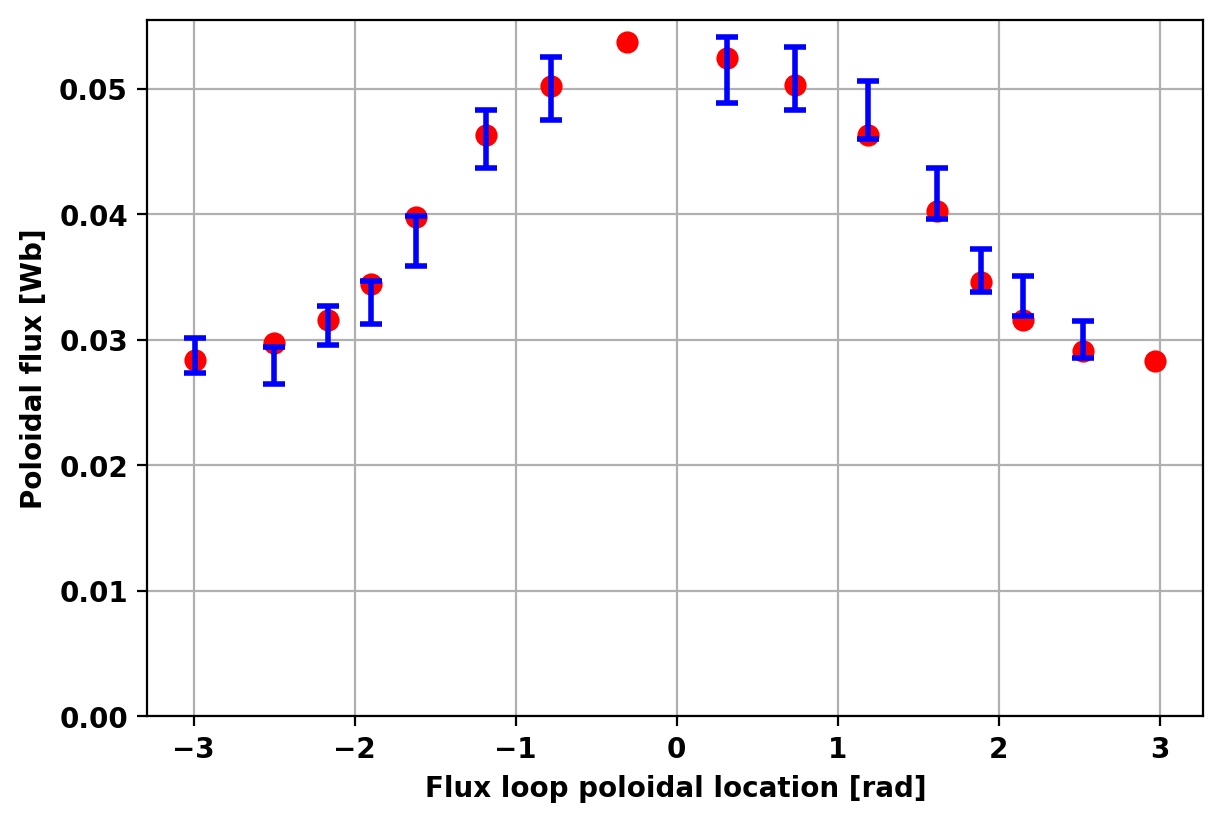

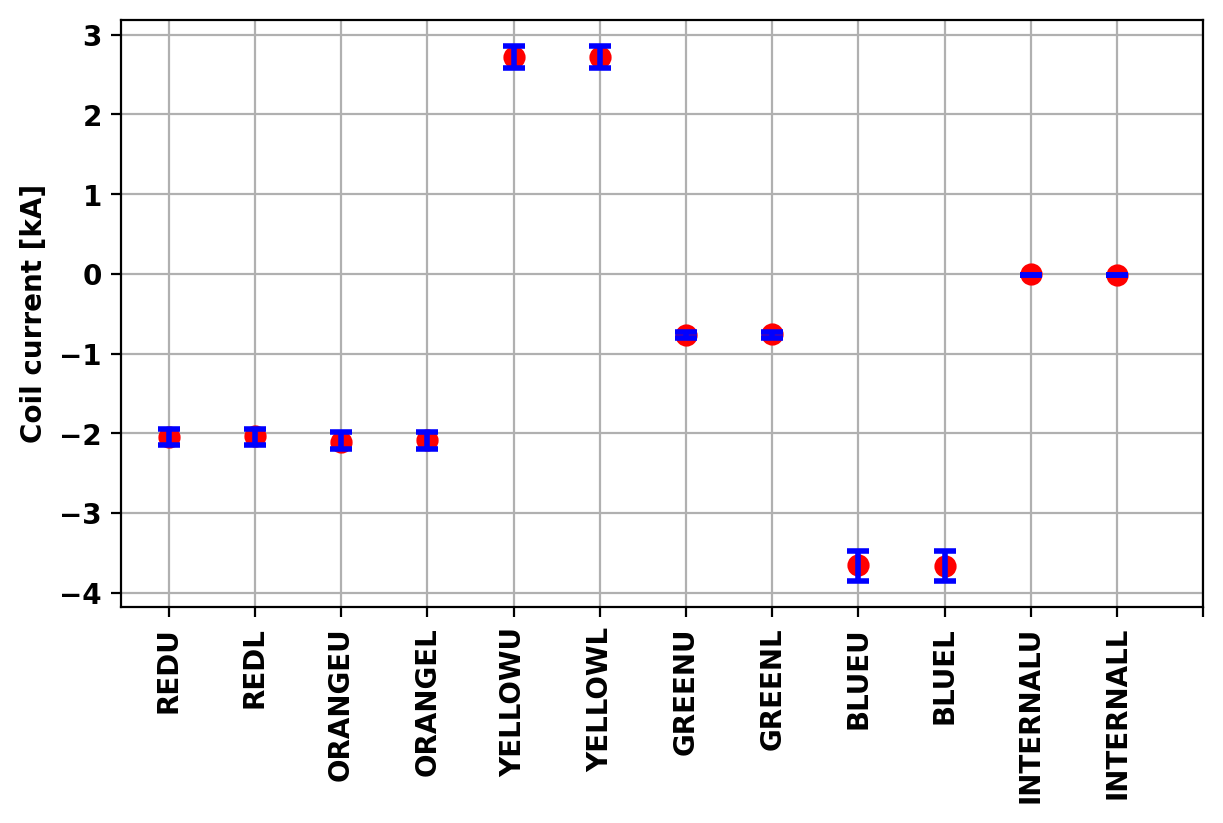

In [16]:
field_eval = mygs.get_field_eval('PSI')
fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(6,4))
for floop in exp_data['floops']:
    theta = np.arctan2(floop['loc'][1],floop['loc'][0]-0.42)
    B_tmp = field_eval.eval(floop['loc'])
    if floop['name'].startswith('CENTERSTACK'):
        continue
    ax.plot(theta,-B_tmp[0]*2.0*np.pi,'ro')
    if floop.get('err_fac',1.0) > 0.0 and floop['val'] is not None:
        ax.errorbar(theta,floop['val'],yerr=0.05*abs(B_tmp[0]*2.0*np.pi),color='b',capsize=4)
ax.set_ylim(bottom=0.0)
ax.grid(True)
ax.set_xlabel('Flux loop poloidal location [rad]')
_ = ax.set_ylabel('Poloidal flux [Wb]')

#
coil_currents, _ = mygs.get_coil_currents()
fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(6,4))
labels = ['' for _ in range(mygs.ncoils)]
i=0
for name, coil_current in coil_currents.items():
    if name.startswith('OH'):
        continue
    labels[i] = name
    ax.plot(i,coil_current/1.E3,'ro')
    ax.errorbar(i,coil_targets[name]/1.E3,yerr=0.05*abs(coil_targets[name])/1.E3,color='b',capsize=4)
    i+=1
ax.grid(True)
ax.set_xticks(range(mygs.ncoils),labels=labels,rotation=90)
_ = ax.set_ylabel('Coil current [kA]')

### Plot equilibrium and eddy currents
We now show the updated equilibrium, this time using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_eddy "plot_eddy()" to show the eddy currents in the vessel due to the change in flux from the preceding equilibrium.

Starting CG solver
     0  0.000000E+00  0.000000E+00  3.641625E-01
     1 -5.399671E+02  3.763905E+03  1.734357E-01  4.607867E-05
     2 -6.419113E+02  3.982962E+03  6.999139E-02  1.757270E-05
     3 -6.579424E+02  4.074126E+03  2.548784E-02  6.256027E-06
     4 -6.603046E+02  4.086530E+03  1.068686E-02  2.615143E-06
     5 -6.606439E+02  4.085241E+03  3.608388E-03  8.832741E-07
     6 -6.606906E+02  4.078966E+03  1.398772E-03  3.429232E-07
     7 -6.606986E+02  4.079058E+03  5.314917E-04  1.302977E-07
     8 -6.606996E+02  4.079325E+03  2.492359E-04  6.109733E-08
     9 -6.606998E+02  4.079399E+03  9.014384E-05  2.209733E-08
    10 -6.606998E+02  4.079462E+03  3.089122E-05  7.572375E-09
    20 -6.606998E+02  4.079444E+03  2.217129E-09  5.434880E-13
Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    1.0476E+05
  Current Centroid [m]    =    0.376 -0.001
  Magnetic Axis [m]       =    0.405 -0.001
  Elongation              =    1.233 (U:  1.233

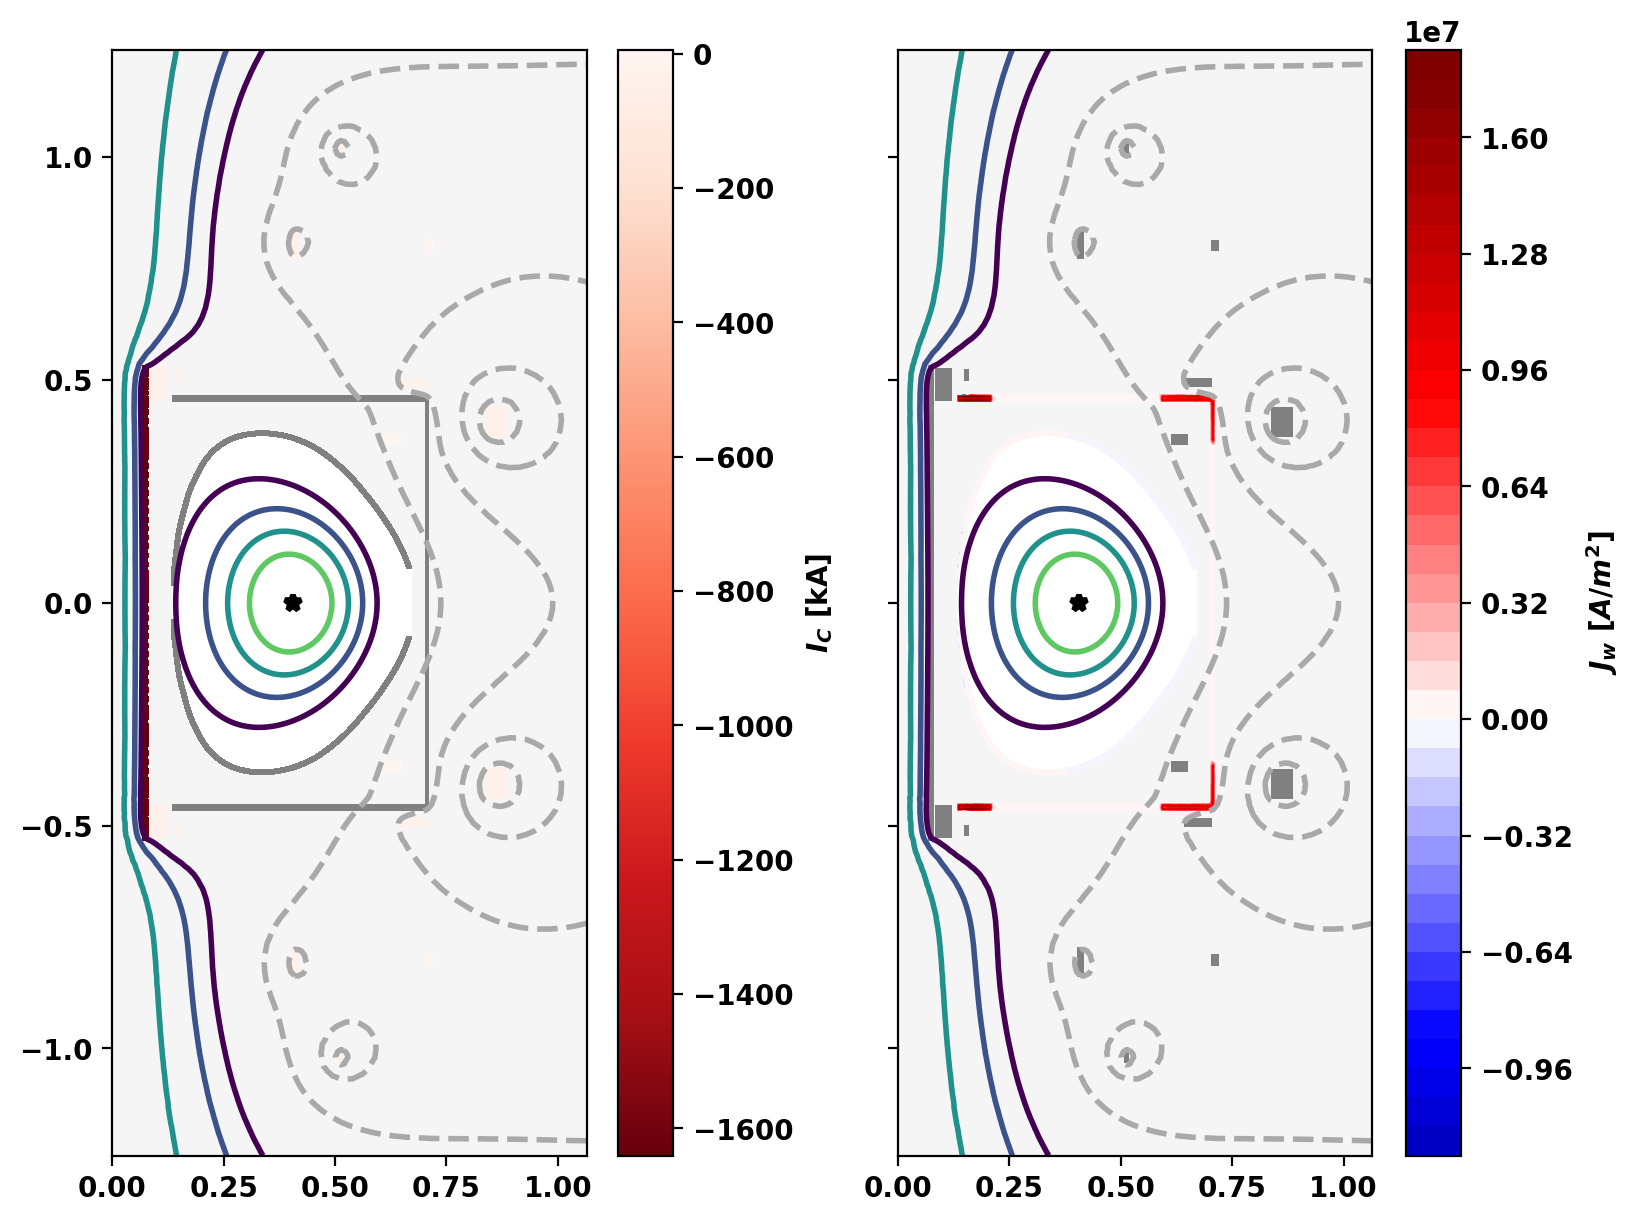

In [17]:
# Plot equilibrium
fig, ax = plt.subplots(1,2,sharey=True,constrained_layout=True,figsize=(8,6))
mygs.plot_machine(fig,ax[0],coil_colormap='Reds_r',coil_scale=1.E-3,coil_clabel=r'$I_C$ [kA]',limiter_color=None)
mygs.plot_psi(fig,ax[0],plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_machine(fig,ax[1],limiter_color=None)
mygs.plot_psi(fig,ax[1],plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_eddy(fig,ax[1],psi=mygs.get_psi(False),colormap='seismic',symmap=True)
# Print information and coil currents
mygs.print_info()
print()
print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key in coil_currents:
    print('  {0:10} {1:10.2F}'.format(key+":",coil_currents[key]/1.E3))

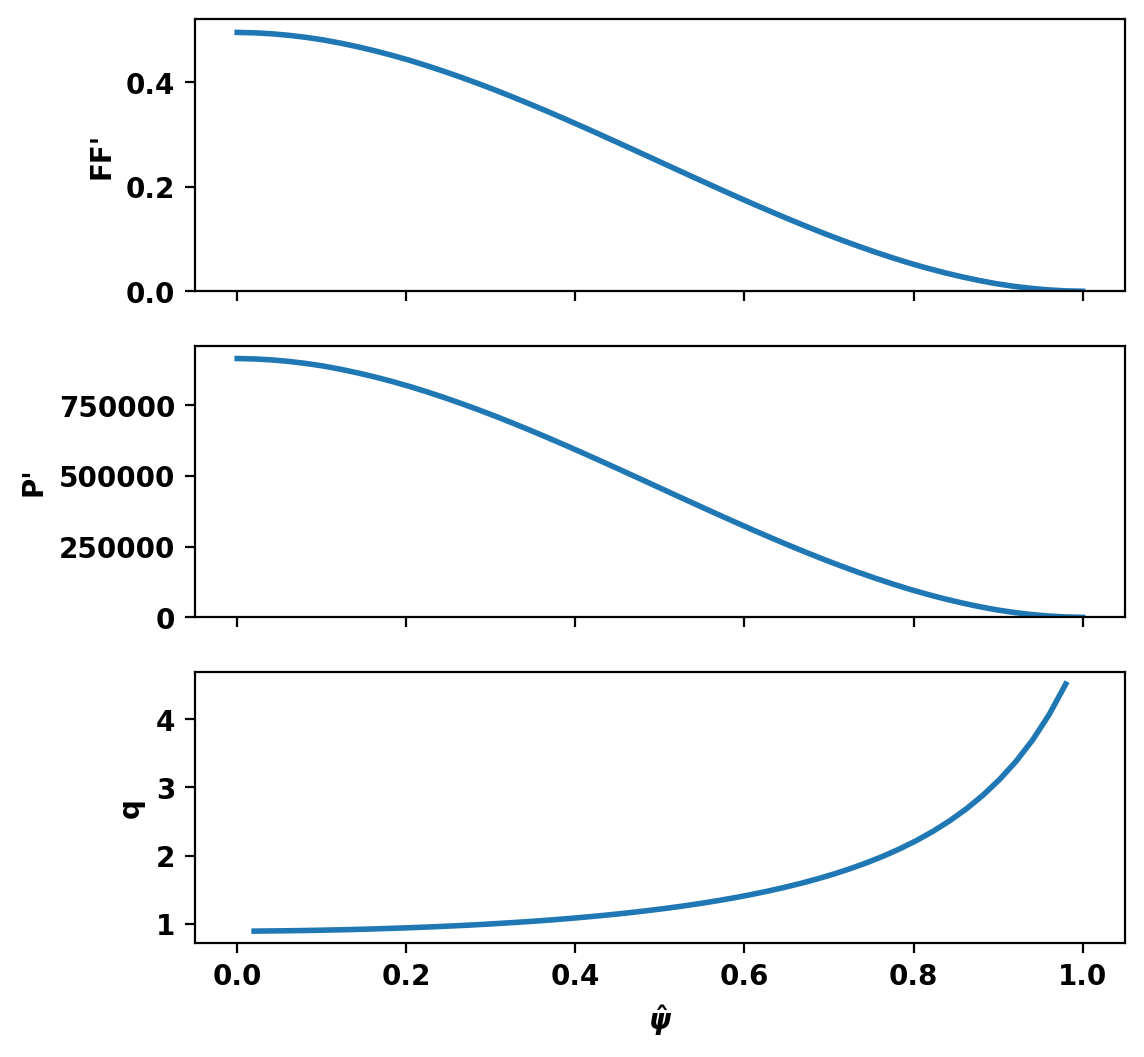

In [18]:
psi,f,fp,p,pp = mygs.get_profiles()
psi_q,qvals,ravgs,dl,rbounds,zbounds = mygs.get_q()
fig, ax = plt.subplots(3,1,sharex=True)
# Plot F*F'
ax[0].plot(psi,f*fp)
ax[0].set_ylim(bottom=0.0)
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(psi,pp)
ax[1].set_ylim(bottom=0.0)
ax[1].set_ylabel("P'")
# Plot q
ax[2].plot(psi_q,qvals)
ax[2].set_ylabel("q")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")